# Music–Emotion Analysis (DEAM Dataset)

**Goal:**  
This notebook explores the relationship between musical emotion dimensions (valence and arousal) using the DEAM dataset.  
It includes basic data analysis, baseline prediction models, and a simple mood-based recommender system.

**Dataset:**  
DEAM – Dynamic Emotion Annotations in Music  
(Using averaged static valence and arousal annotations)


## 1. Dataset Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv("../data/static_annotations_averaged_songs_1_2000.csv")
df2 = pd.read_csv("../data/static_annotations_averaged_songs_2000_2058.csv")

df = pd.concat([df1, df2], ignore_index=True)

df.head()

,song_id,valence_mean,valence_std,arousal_mean,arousal_std,valence_ max_mean,valence_max_std,valence_min_mean,valence_min_std,arousal_max_mean,arousal_max_std,arousal_min_mean,arousal_min_std
0,2,3.1,0.94,3.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,3.5,1.75,3.3,1.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,5.7,1.42,5.5,1.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,4.4,2.01,5.3,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,5.8,1.47,6.4,1.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Understanding & Sanity Checks


In [2]:
print(df.shape)
df.columns

(1802, 13)


Index(['song_id', ' valence_mean', ' valence_std', ' arousal_mean',
       ' arousal_std', ' valence_ max_mean', ' valence_max_std',
       ' valence_min_mean', ' valence_min_std', ' arousal_max_mean',
       ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std'],
      dtype='object')

In [3]:
#clean the extra space 
df.columns = df.columns.str.strip()
df.columns


Index(['song_id', 'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std',
       'valence_ max_mean', 'valence_max_std', 'valence_min_mean',
       'valence_min_std', 'arousal_max_mean', 'arousal_max_std',
       'arousal_min_mean', 'arousal_min_std'],
      dtype='object')

In [5]:
val_col = "valence_mean"
aro_col = "arousal_mean"
df[[val_col, aro_col]].describe()


,valence_mean,arousal_mean
count,1802.000000,1802.000000
mean,4.904145,4.814029
std,1.174240,1.282187
min,1.600000,1.600000
25%,4.100000,3.800000
50%,4.900000,4.900000
75%,5.800000,5.800000
max,8.400000,8.100000


In [6]:
# Check missing values per column
df.isna().sum()


song_id                 0
valence_mean            0
valence_std             0
arousal_mean            0
arousal_std             0
valence_ max_mean    1744
valence_max_std      1744
valence_min_mean     1744
valence_min_std      1744
arousal_max_mean     1744
arousal_max_std      1744
arousal_min_mean     1744
arousal_min_std      1744
dtype: int64

In [7]:
# Check duplicate song IDs
df["song_id"].duplicated().sum()


np.int64(0)

In [8]:
df[[val_col, aro_col]].agg(["min", "max"])



,valence_mean,arousal_mean
min,1.6,1.6
max,8.4,8.1


The dataset contains 1802 songs with valence and arousal annotations.
The main target variables (valence_mean, arousal_mean) contain no missing values and lie approximately on a 1–9 scale.


## 3. Exploratory Analysis


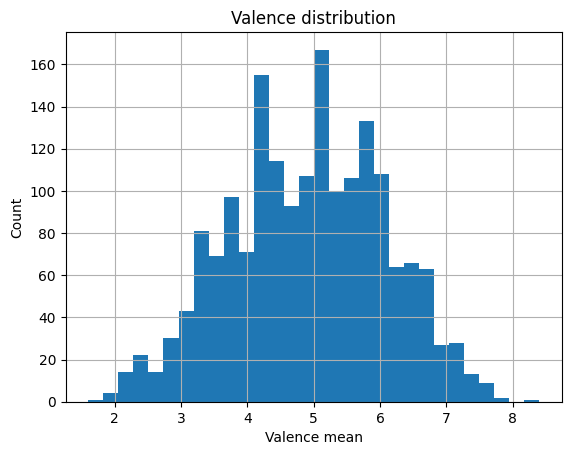

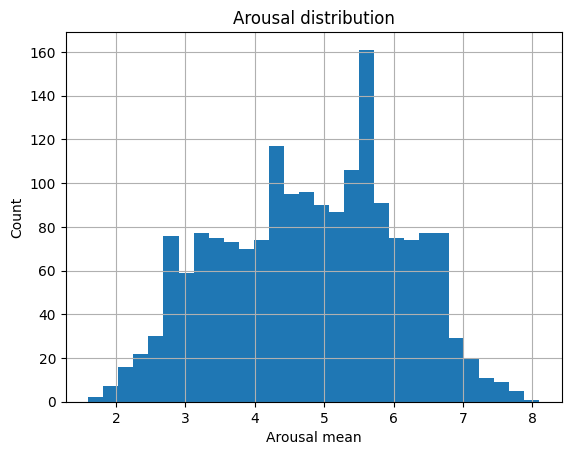

In [9]:
plt.figure()
df[val_col].hist(bins=30)
plt.title("Valence distribution")
plt.xlabel("Valence mean")
plt.ylabel("Count")
plt.show()

plt.figure()
df[aro_col].hist(bins=30)
plt.title("Arousal distribution")
plt.xlabel("Arousal mean")
plt.ylabel("Count")
plt.show()


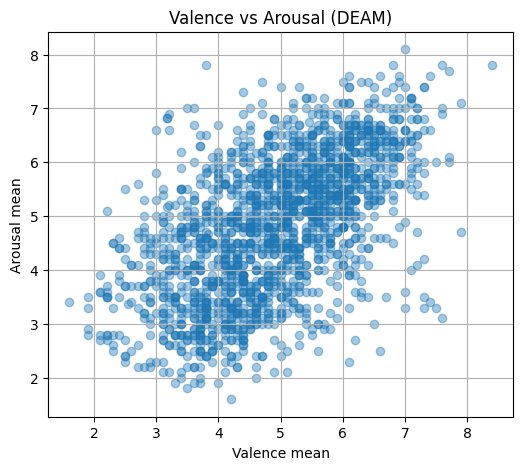

In [10]:
plt.figure(figsize=(6, 5))
plt.scatter(df[val_col], df[aro_col], alpha=0.4)
plt.title("Valence vs Arousal (DEAM)")
plt.xlabel("Valence mean")
plt.ylabel("Arousal mean")
plt.grid(True)
plt.show()


In [11]:
corr = df[[val_col, aro_col]].corr().loc[val_col, aro_col]
corr

np.float64(0.570026063957971)

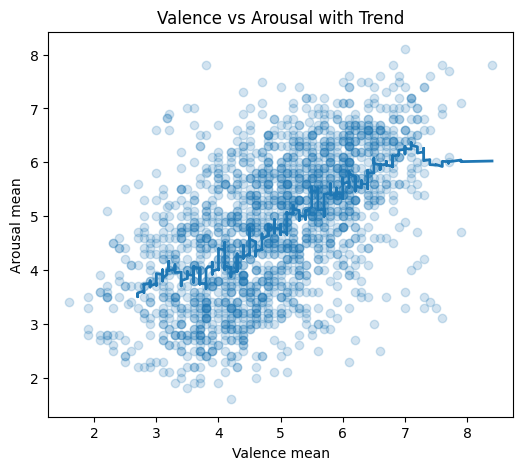

In [12]:
import numpy as np

# sort by valence to visualize trend
sorted_idx = np.argsort(df[val_col])
plt.figure(figsize=(6,5))
plt.scatter(df[val_col], df[aro_col], alpha=0.2)
plt.plot(df[val_col].iloc[sorted_idx],
         df[aro_col].iloc[sorted_idx].rolling(50).mean(),
         linewidth=2)
plt.xlabel("Valence mean")
plt.ylabel("Arousal mean")
plt.title("Valence vs Arousal with Trend")
plt.show()


Valence vs Arousal: The correlation between valence and arousal is 0.57, indicating a moderate positive relationship. While higher valence songs tend to have higher arousal on average, the relationship is noisy, with substantial variability across songs.
- Valence and arousal are related but not redundant
- Predicting one from the other will have limited accuracy

## 4. Baseline Prediction Models


Can we predict arousal just from valence?
- X = input features
- y = target to predict
- 80% training
- 20% testing
- fixed random seed

In [13]:
X = df[[val_col]]      # feature(s) 
y = df[aro_col]        # target 

X.shape, y.shape


((1802, 1), (1802,))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1441, 1), (361, 1))

train a model to always predict the average arousal from the training set.


In [15]:
# Baseline prediction: mean of training target
baseline_pred = y_train.mean()
baseline_pred


np.float64(4.83115891741846)

In [16]:
from sklearn.metrics import mean_absolute_error

y_pred_baseline = [baseline_pred] * len(y_test)

#If I ignore valence completely and always guess the average arousal, how wrong am I?
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mae


1.0050025663157127

On average, our baseline is off by about 1 arousal point.

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mae


0.8508350569993477

Baseline vs Linear Regression:
The baseline model (predicting mean arousal) achieved an MAE of 1.00 , while a linear regression using valence achieved an MAE of 0.85.
The linear model improves over the baseline, indicating that valence provides some predictive information for arousal.
If arousal were perfectly predictable from valence, MAE would be close to 0
If arousal were random noise, MAE would be almost unchanged from baseline
we are in the middle.

Can we predict valence just from arousal?
- X = input features
- y = target to predict
- 80% training
- 20% testing
- fixed random seed

In [18]:
X = df[[aro_col]]      # feature(s) must be 2D
y = df[val_col]        # target is 1D

X.shape, y.shape

((1802, 1), (1802,))

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((1441, 1), (361, 1))

train a model to always predict the average valence from the training set.


In [20]:
# Baseline prediction: mean of training target
baseline_pred = y_train.mean()
baseline_pred

np.float64(4.924476058292853)

In [21]:
from sklearn.metrics import mean_absolute_error

y_pred_baseline = [baseline_pred] * len(y_test)

#If I ignore arousal completely and always guess the average valence, how wrong am I?
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mae

0.9670399518647599

On average, our baseline is off by about 0.96 arousal point.

In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mae

0.797872025169035

Baseline vs Linear Regression:
The baseline model (predicting mean arousal) achieved an MAE of 0.96 , while a linear regression using valence achieved an MAE of 0.79.
The linear model improves over the baseline, indicating that arousal provides some predictive information for valence.

## 5. Model Interpretation & Evaluation


In [23]:
#Inspect the linear regression coefficients
coef = model.coef_[0]
intercept = model.intercept_
coef, intercept


(np.float64(0.5330723312565849), np.float64(2.349118911513555))

Linear regression is:
prediction=(slope×valence)+intercept
If valence goes up by 1, arousal goes up by 0.647 and when valence is 0 (which never happens), arousal would be 1.642 (offset). 
Linear model interpretation:
The linear regression model learns a positive relationship between valence and arousal. The coefficient indicates that an increase of one unit in valence corresponds to an increase of approximately 0.647 in predicted arousal. This aligns with the observed positive correlation between the two variables.

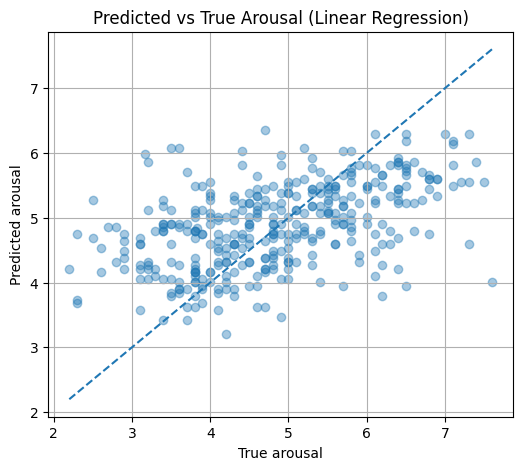

In [24]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("True arousal")
plt.ylabel("Predicted arousal")
plt.title("Predicted vs True Arousal (Linear Regression)")
plt.grid(True)
plt.show()


The predicted-versus-true plot shows that the model captures the general trend between valence and arousal but exhibits substantial scatter around the diagonal. This indicates that while valence contributes to arousal prediction, additional features would be required for accurate estimation.

In [25]:
#Inspect the linear regression coefficients
coef = model.coef_[0]
intercept = model.intercept_
coef, intercept

(np.float64(0.5330723312565849), np.float64(2.349118911513555))

Linear regression is:
prediction=(slope×arousal)+intercept
If arousal goes up by 1, valence goes up by 0.533 and when arousal is 0 (which never happens), valence would be 2.349 (offset). 
Linear model interpretation:
The linear regression model learns a positive relationship between valence and arousal. The coefficient indicates that an increase of one unit in arousal corresponds to an increase of approximately 0.533 in predicted valence. This aligns with the observed positive correlation between the two variables.

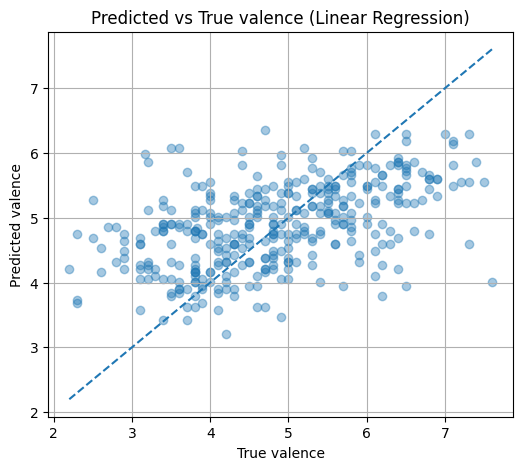

In [26]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("True valence")
plt.ylabel("Predicted valence")
plt.title("Predicted vs True valence (Linear Regression)")
plt.grid(True)
plt.show()

The predicted-versus-true plot shows that the model captures the general trend between valence and arousal but exhibits substantial scatter around the diagonal. This indicates that while arousal contributes to valence prediction, additional features would be required for accurate estimation.
Predicting valence from arousal yields similar performance to predicting arousal from valence. This symmetry reflects the moderate correlation between the two emotion dimensions, indicating that while they are related, neither dimension can be accurately predicted from the other alone.

Conclusion:
Simple linear models using only valence or arousal outperform a constant baseline, indicating a moderate relationship between the two emotion dimensions. However, prediction errors remain substantial, highlighting that valence and arousal capture complementary but distinct aspects of musical emotion. More expressive features would be required for accurate emotion prediction.

------------------------------------------------------------------------------------------------------------------

## 6. Mood-Based Recommender System


given a song, find the k most similar songs in valence–arousal space.
- Represent each song as a 2D point: (valence_mean, arousal_mean)
- Define “similar mood” = closest points (smallest distance)
- Return the top k nearest songs (by song_id)

In [27]:
#We want a small table with only what the recommender needs.
mood_df = df[["song_id", val_col, aro_col]].copy()
mood_df.head()


,song_id,valence_mean,arousal_mean
0,2,3.1,3.0
1,3,3.5,3.3
2,4,5.7,5.5
3,5,4.4,5.3
4,7,5.8,6.4


In [28]:
#standardizing makes distance comparisons more stable
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_mood = scaler.fit_transform(mood_df[[val_col, aro_col]])
X_mood[:5]


array([[-1.53686358, -1.41518526],
       [-1.19612306, -1.18114512],
       [ 0.67794977,  0.53514929],
       [-0.4294569 ,  0.37912252],
       [ 0.7631349 ,  1.23726973]])

In [29]:
#Show me the most similar points with KNN
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=6, metric="euclidean")  # 6 = query song + 5 neighbors
knn.fit(X_mood)


,n_neighbors,6
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'euclidean'
,p,2
,metric_params,None
,n_jobs,None


In [30]:
import numpy as np

def recommend_similar_songs(song_id: int, k: int = 5):
    # Find row index of the given song_id
    matches = mood_df.index[mood_df["song_id"] == song_id].tolist()
    if len(matches) == 0:
        raise ValueError(f"song_id {song_id} not found. Try a valid id from mood_df['song_id'].head().")
    idx = matches[0]
    
    # Query kNN on this song
    distances, indices = knn.kneighbors([X_mood[idx]], n_neighbors=k+1)  # +1 to include itself
    distances = distances[0]
    indices = indices[0]
    
    # Build result table (skip the first because it's the same song)
    recs = mood_df.iloc[indices].copy()
    recs["distance"] = distances
    recs = recs.iloc[1:]  # remove the query song itself
    
    # Nice ordering
    recs = recs[["song_id", val_col, aro_col, "distance"]].reset_index(drop=True)
    return recs


In [31]:
example_id = int(mood_df["song_id"].iloc[0])  # pick the first song in your table
example_id

2

In [32]:
recommend_similar_songs(example_id, k=5)

,song_id,valence_mean,arousal_mean,distance
0,565,3.1,3.0,0.000000
1,1123,3.1,3.1,0.078013
2,1111,3.2,2.9,0.115510
3,1024,3.2,2.9,0.115510
4,707,3.2,3.1,0.115510


A distance of zero indicates songs with identical valence–arousal annotations, resulting in perfectly overlapping mood representations.

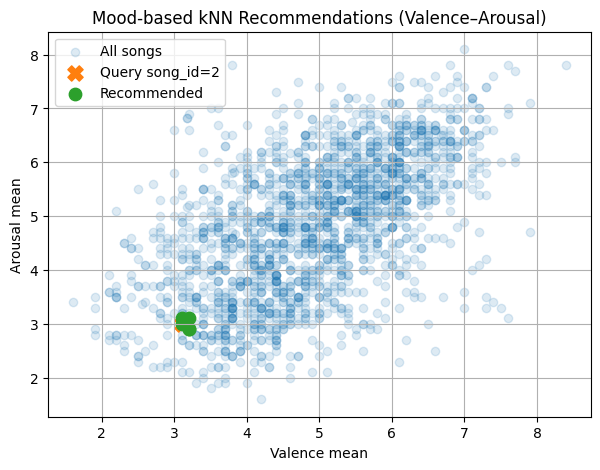

In [33]:
recs = recommend_similar_songs(example_id, k=5)

query_row = mood_df[mood_df["song_id"] == example_id].iloc[0]

plt.figure(figsize=(7, 5))
plt.scatter(mood_df[val_col], mood_df[aro_col], alpha=0.15, label="All songs")
plt.scatter([query_row[val_col]], [query_row[aro_col]], marker="X", s=120, label=f"Query song_id={example_id}")
plt.scatter(recs[val_col], recs[aro_col], s=80, label="Recommended")

plt.xlabel("Valence mean")
plt.ylabel("Arousal mean")
plt.title("Mood-based kNN Recommendations (Valence–Arousal)")
plt.grid(True)
plt.legend()
plt.show()


Mood-based recommender:
Songs are represented in a two-dimensional valence–arousal space and standardized before computing distances. Using k-nearest neighbors, the system retrieves songs with the most similar emotional profiles. The visualization shows that recommended songs cluster closely around the query song, indicating successful mood-based similarity retrieval.

In [34]:
recs.to_csv("../results/recommendations_example.csv", index=False)
"Saved to results/recommendations_example.csv"


'Saved to results/recommendations_example.csv'

## 7. Conclusion & Next Steps

This project demonstrates a simple but complete pipeline for music emotion analysis, including data validation, exploratory analysis, baseline prediction models, and a mood-based recommender system.  
Results show that valence and arousal are moderately related but capture distinct aspects of musical emotion.

**Next steps** could include:
- incorporating audio features,
- experimenting with nonlinear models,
- or extending the recommender with user preferences.
